<a href="https://colab.research.google.com/github/jeffheaton/pretrained-gan-tech/blob/main/tech-gan.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Tech GAN

![Test](https://github.com/jeffheaton/pretrained-gan-tech/blob/main/tech-gan-img.jpg?raw=true)
* Copyright 2021 [Jeff Heaton](https://www.heatonresearch.com/), [MIT License](https://opensource.org/licenses/MIT)

I created a GAN neural network to generate technology images at 1024x1024 resolution.  The results of this training are contained in the Git repository.  

Other resources:

* [My Docker Images for Creating/Training GAN neural Networks](https://hub.docker.com/r/heatonresearch/stylegan2-ada)

You can use this notebook to generate images useing a prebuilt GAN that I created. A GPU is required, this notebook is designed to work with Google CoLab. This notebook only deals with running the GAN to produce images.  To actually train the GAN, I used the following Docker image:

* [Heaton Research StyleGAN2 ADA Docker Image](https://hub.docker.com/r/heatonresearch/stylegan2-ada)
* [Collect Flickr Images](https://github.com/jeffheaton/pyimgdata)

To produce images, first, clone StyleGAN2 ADA from GitHub.

In [ ]:
!git clone https://github.com/NVlabs/stylegan2-ada-pytorch.git
!pip install ninja

import sys
sys.path.insert(0, "/content/stylegan2-ada-pytorch")
import pickle
import os
import numpy as np
import PIL.Image
from IPython.display import Image
import matplotlib.pyplot as plt
import IPython.display
import torch
import dnnlib
import legacy

def seed2vec(G, seed):
  return np.random.RandomState(seed).randn(1, G.z_dim)

def display_image(image):
  plt.axis('off')
  plt.imshow(image)
  plt.show()

def generate_image(G, z, truncation_psi):
    # Render images for dlatents initialized from random seeds.
    Gs_kwargs = {
        'output_transform': dict(func=tflib.convert_images_to_uint8, nchw_to_nhwc=True),
        'randomize_noise': False
    }
    if truncation_psi is not None:
        Gs_kwargs['truncation_psi'] = truncation_psi

    label = np.zeros([1] + G.input_shapes[1][1:])
    images = G.run(z, label, **G_kwargs) # [minibatch, height, width, channel]
    return images[0]

def get_label(G, device, class_idx):
  label = torch.zeros([1, G.c_dim], device=device)
  if G.c_dim != 0:
      if class_idx is None:
          ctx.fail('Must specify class label with --class when using a conditional network')
      label[:, class_idx] = 1
  else:
      if class_idx is not None:
          print ('warn: --class=lbl ignored when running on an unconditional network')
  return label

def generate_image(device, G, z, truncation_psi=1.0, noise_mode='const', class_idx=None):
  z = torch.from_numpy(z).to(device)
  label = get_label(G, device, class_idx)
  img = G(z, label, truncation_psi=truncation_psi, noise_mode=noise_mode)
  img = (img.permute(0, 2, 3, 1) * 127.5 + 128).clamp(0, 255).to(torch.uint8)
  #PIL.Image.fromarray(img[0].cpu().numpy(), 'RGB').save(f'{outdir}/seed{seed:04d}.png')
  return PIL.Image.fromarray(img[0].cpu().numpy(), 'RGB')

Cloning into 'stylegan2-ada-pytorch'...
remote: Enumerating objects: 125, done.
remote: Total 125 (delta 0), reused 0 (delta 0), pack-reused 125
Receiving objects: 100% (125/125), 1.12 MiB | 17.92 MiB/s, done.
Resolving deltas: 100% (55/55), done.
     |████████████████████████████████| 108 kB 8.5 MB/s 


Now load the correct GAN, I have several links below that corrispond to both the NVIDIA faces GAN, as well as my own.

In [ ]:
URL = "https://github.com/jeffheaton/pretrained-gan-tech/releases/download/v1.0/tech-gan-2021-10-12.pkl"
#URL = "https://nvlabs-fi-cdn.nvidia.com/stylegan2-ada/pretrained/ffhq.pkl"

print('Loading networks from "%s"...' % URL)
device = torch.device('cuda')
with dnnlib.util.open_url(URL) as fp:
    G = legacy.load_network_pkl(fp)['G_ema'].requires_grad_(False).to(device) # type: ignore

Loading networks from "https://github.com/jeffheaton/pretrained-gan-tech/releases/download/v1.0/tech-gan-2021-10-12.pkl"...


# Generate and View GANS from Seeds

A GAN is actually created from a 512 number latent vector.  However, for now it is easier to just use seeds to build this 512 vector.  This code generates images between two seed numbers.

Seed 4020
Setting up PyTorch plugin "bias_act_plugin"... Done.
Setting up PyTorch plugin "upfirdn2d_plugin"... Done.


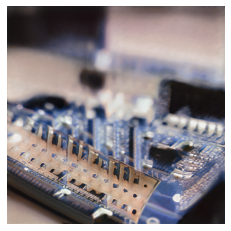

Seed 4021


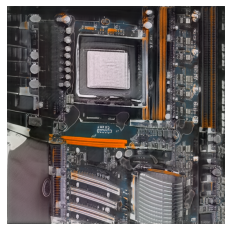

Seed 4022


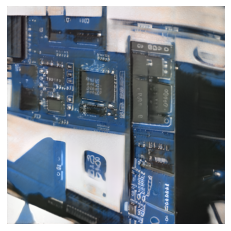

In [ ]:
# Choose your own starting and ending seed.
SEED_FROM = 4020
SEED_TO = 4023

# Generate the images for the seeds.
for i in range(SEED_FROM, SEED_TO):
  print(f"Seed {i}")
  z = seed2vec(G, i)
  img = generate_image(device, G, z)
  display_image(img)

# Generate a Large Number of Images and Download

Generate a potentially large number of images to download.  

In [ ]:
# Choose your own starting and ending seed.
SEED_FROM = 3000
SEED_TO = 3100

from tqdm.notebook import tqdm

!mkdir /content/images/

# Generate the images for the seeds.
for i in tqdm(range(SEED_FROM, SEED_TO)):
  z = seed2vec(G, i)
  img = generate_image(device, G, z)
  img.save(f'/content/images/seed-{i}.jpg')

  0%|          | 0/100 [00:00<?, ?it/s]

Zip the generated images.

In [ ]:
!zip -qr images.zip /content/images 

Download generated images, this can take awhile, even before the actual download starts. It might also work better to map GDrive and copy the fies there, if you have a large number of files.

In [ ]:
from google.colab import files
files.download('images.zip')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

# Morph Video

You can create a video that shows the progression through two GAN seeds.  This technique creates a very cool "morph" effect. 

![GAN](https://raw.githubusercontent.com/jeffheaton/t81_558_deep_learning/master/images/gan_progression.jpg "GAN")

In [ ]:
# Choose your seeds to morph through and the number of steps to take to get to each.

SEEDS = [3001, 3003, 3004, 3010,3011, 3014, 3017,3019,3021, 3023]
STEPS = 100

# Remove any prior results
!rm /content/results/* 

from tqdm.notebook import tqdm

os.makedirs("./results/", exist_ok=True)

# Generate the images for the video.
idx = 0
for i in range(len(SEEDS)-1):
  v1 = seed2vec(G, SEEDS[i])
  v2 = seed2vec(G, SEEDS[i+1])

  diff = v2 - v1
  step = diff / STEPS
  current = v1.copy()

  for j in tqdm(range(STEPS), desc=f"Seed {SEEDS[i]}"):
    current = current + step

    img = generate_image(device, G, current)
    img.save(f'./results/frame-{idx}.png')
    idx+=1
 
# Link the images into a video.
!ffmpeg -r 30 -i /content/results/frame-%d.png -vcodec mpeg4 -y movie.mp4

rm: cannot remove '/content/results/*': No such file or directory


Seed 3001:   0%|          | 0/100 [00:00<?, ?it/s]

Seed 3003:   0%|          | 0/100 [00:00<?, ?it/s]

Seed 3004:   0%|          | 0/100 [00:00<?, ?it/s]

Seed 3010:   0%|          | 0/100 [00:00<?, ?it/s]

Seed 3011:   0%|          | 0/100 [00:00<?, ?it/s]

Seed 3014:   0%|          | 0/100 [00:00<?, ?it/s]

Seed 3017:   0%|          | 0/100 [00:00<?, ?it/s]

Seed 3019:   0%|          | 0/100 [00:00<?, ?it/s]

Seed 3021:   0%|          | 0/100 [00:00<?, ?it/s]

ffmpeg version 3.4.8-0ubuntu0.2 Copyright (c) 2000-2020 the FFmpeg developers
  built with gcc 7 (Ubuntu 7.5.0-3ubuntu1~18.04)
  configuration: --prefix=/usr --extra-version=0ubuntu0.2 --toolchain=hardened --libdir=/usr/lib/x86_64-linux-gnu --incdir=/usr/include/x86_64-linux-gnu --enable-gpl --disable-stripping --enable-avresample --enable-avisynth --enable-gnutls --enable-ladspa --enable-libass --enable-libbluray --enable-libbs2b --enable-libcaca --enable-libcdio --enable-libflite --enable-libfontconfig --enable-libfreetype --enable-libfribidi --enable-libgme --enable-libgsm --enable-libmp3lame --enable-libmysofa --enable-libopenjpeg --enable-libopenmpt --enable-libopus --enable-libpulse --enable-librubberband --enable-librsvg --enable-libshine --enable-libsnappy --enable-libsoxr --enable-libspeex --enable-libssh --enable-libtheora --enable-libtwolame --enable-libvorbis --enable-libvpx --enable-libwavpack --enable-libwebp --enable-libx265 --enable-libxml2 --enable-libxvid --enable-lib

Download the video.

In [ ]:
from google.colab import files
files.download('movie.mp4')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

# Finetune an Image

If you find a seed that you like, you can fine tune it by adjusting the latent vector directly.  First, choose the seed to finetune.

In [ ]:
START_SEED = 4090

current = seed2vec(G, START_SEED)

In [ ]:
z.shape

(1, 512)

Next, generate display the current vector. You will return to this point for each iteration of the finetuning.

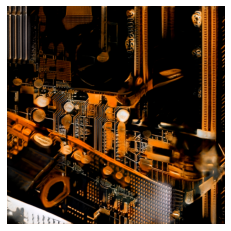

In [ ]:
img = generate_image(device, G, current)

SCALE = 0.5
display_image(img)

Choose an explore size, this is the number of differnt potential images that will be chosen by moving in 10 different directions.  Run this code once initially, and then again anytime you wish to change the 10 directions you are exploring.  You might change the 10 directions if you are no longer seeing improvements.

In [ ]:
EXPLORE_SIZE = 25

explore = []
for i in range(EXPLORE_SIZE):
  explore.append( np.random.rand(1, 512) - 0.5 )

Direction 0


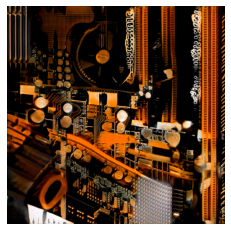

Direction 1


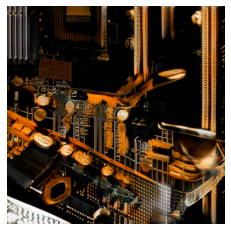

Direction 2


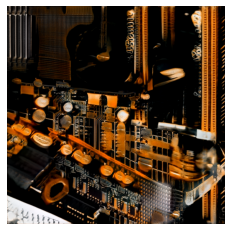

Direction 3


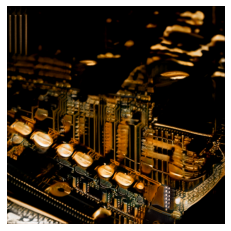

Direction 4


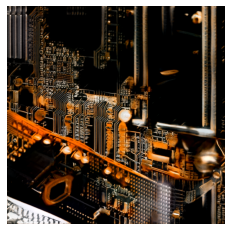

Direction 5


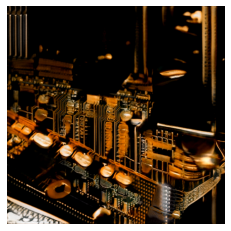

Direction 6


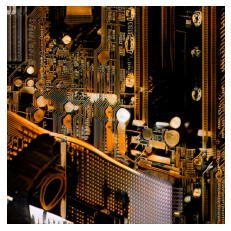

Direction 7


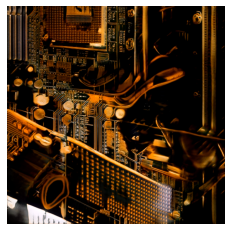

Direction 8


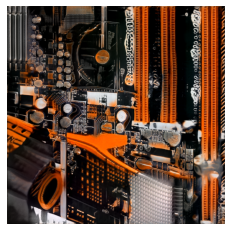

Direction 9


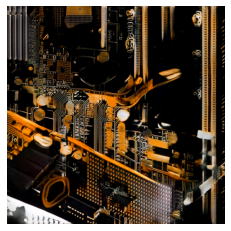

Direction 10


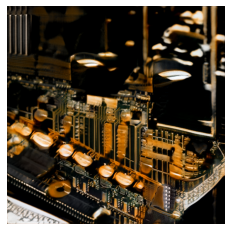

Direction 11


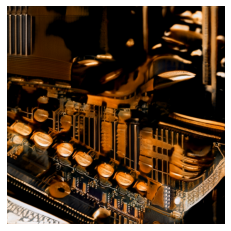

Direction 12


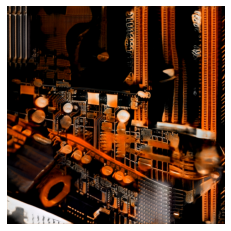

Direction 13


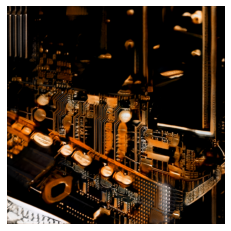

Direction 14


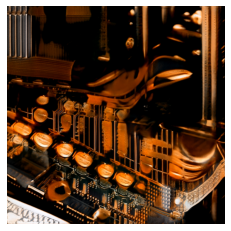

Direction 15


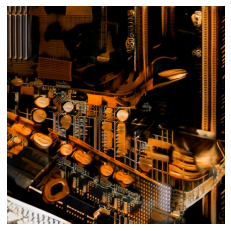

Direction 16


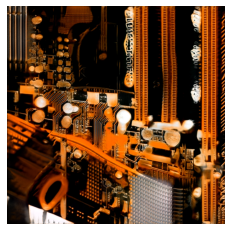

Direction 17


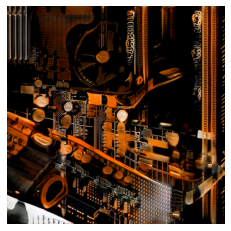

Direction 18


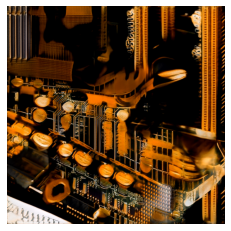

Direction 19


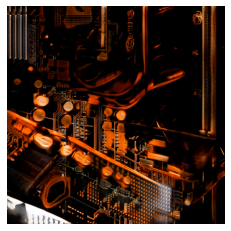

Direction 20


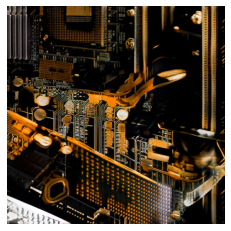

Direction 21


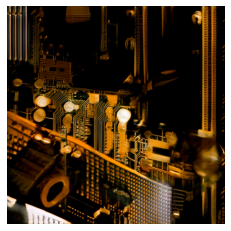

Direction 22


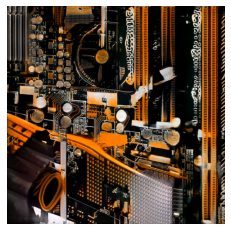

Direction 23


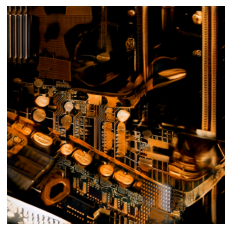

Direction 24


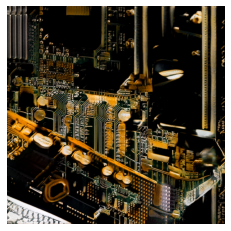

In [ ]:
# Choose the direction to move.  Choose -1 for the initial iteration.   
MOVE_DIRECTION = -1
SCALE = 0.5

if MOVE_DIRECTION >=0:
  current = current + explore[MOVE_DIRECTION]

for i, mv in enumerate(explore):
  print(f"Direction {i}")
  z = current + mv
  img = generate_image(device, G, z)
  display_image(img)